# Neural Network Model Complexity Analysis

This notebook builds neural networks of increasing complexity to predict ranked returns and analyzes the trade-off between model complexity and performance on training vs. test data.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Load and Filter Data

In [2]:
# Read the parquet file
df = pd.read_parquet('data4.parquet')

# Display initial info
print(f"Original data shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDate range: {df['month'].min()} to {df['month'].max()}")
print(f"\nFirst few rows:")
print(df.head())

Original data shape: (589006, 17)

Columns: ['ticker', 'month', 'return', 'momentum', 'lagged_return', 'close', 'marketcap', 'pb', 'asset_growth', 'roe', 'gp_to_assets', 'grossmargin', 'assetturnover', 'leverage', 'sector', 'industry', 'size']

Date range: 2011-02 to 2025-10

First few rows:
  ticker    month  return  momentum  lagged_return  close  marketcap   pb  \
0      A  2011-02  0.0060    0.4781         0.0097  41.83    14540.3  4.5   
1      A  2011-03  0.0641    0.3296         0.0060  42.08    14627.2  4.5   
2      A  2011-04  0.1146    0.2236         0.0641  44.78    15454.6  4.6   
3      A  2011-05 -0.0008    0.2349         0.1146  49.91    17225.0  5.2   
4      A  2011-06  0.0249    0.5423        -0.0008  49.87    17211.2  5.2   

   asset_growth    roe  gp_to_assets  grossmargin  assetturnover  leverage  \
0        0.2738  0.243        0.3022        0.538          0.638    3.0037   
1        0.2738  0.243        0.3022        0.538          0.638    3.0037   
2        0

In [3]:
# Filter for Oct 2024 through Oct 2025
df['month'] = pd.to_datetime(df['month'])
df = df[(df['month'] >= '2024-10-01') & (df['month'] <= '2025-10-31')].copy()

print(f"Filtered data shape: {df.shape}")
print(f"Date range: {df['month'].min()} to {df['month'].max()}")
print(f"Unique months: {df['month'].nunique()}")

Filtered data shape: (38571, 17)
Date range: 2024-10-01 00:00:00 to 2025-10-01 00:00:00
Unique months: 13


## Preprocess Data

In [ ]:
# Drop close column
if 'close' in df.columns:
    df = df.drop('close', axis=1)
    print("Dropped 'close' column")

# Drop only industry (too many categories)
if 'industry' in df.columns:
    df = df.drop('industry', axis=1)
    print("Dropped 'industry' column (too many categories)")

print(f"\nRemaining columns: {df.columns.tolist()}")

In [ ]:
# One-hot encode sector and size
print("One-hot encoding categorical variables...")
print(f"\nBefore encoding:")
print(f"  Unique sectors: {df['sector'].nunique()}")
print(f"  Unique sizes: {df['size'].nunique()}")
print(f"  Shape: {df.shape}")

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=['sector', 'size'], drop_first=False)

print(f"\nAfter encoding:")
print(f"  Shape: {df_encoded.shape}")
print(f"  New columns added: {df_encoded.shape[1] - df.shape[1]}")

# Show the new column names
new_cols = [col for col in df_encoded.columns if col.startswith('sector_') or col.startswith('size_')]
print(f"\nOne-hot encoded columns ({len(new_cols)} total):")
for col in sorted(new_cols):
    print(f"  - {col}")

# Replace df with encoded version
df = df_encoded
print(f"\nFinal columns: {df.columns.tolist()}")

### Handling Categorical Variables

In this analysis, we use **different approaches** for different categorical variables:

**Variables Included (One-Hot Encoded):**
- **`sector`**: ~11 sectors (e.g., Technology, Healthcare, Financials)
- **`size`**: 3 categories (Large-Cap, Mid-Cap, Small-Cap)

**Variable Dropped:**
- **`industry`**: ~140 industries - too many categories would add excessive dimensionality

**Why One-Hot Encoding?**

Neural networks require numeric inputs, so we convert categorical variables to binary (0/1) features:

```python
# One-hot encoding creates binary columns for each category
df_encoded = pd.get_dummies(df, columns=['sector', 'size'], drop_first=False)
```

**Example:** A Healthcare Large-Cap stock would have:
- `sector_Healthcare = 1`, all other `sector_*` columns = 0
- `size_Large-Cap = 1`, all other `size_*` columns = 0

**Why Include Sector and Size?**

1. **Sector effects**: Different sectors (Tech vs Utilities) have systematically different return patterns
2. **Size effects**: Large-cap stocks behave differently from small-cap stocks (liquidity, volatility, growth)
3. **Manageable dimensionality**: Adding ~14 binary features is reasonable with 35,000+ training samples
4. **Financial research**: Sector and size are well-known factors in asset pricing models

**Why Drop Industry?**

1. **Too granular**: ~140 industries would add 140 features
2. **Overfitting risk**: Too many sparse features relative to sample size
3. **Hierarchy**: Sector already captures the broader industry classification

**Important Note on Ranking:**

We apply one-hot encoding **before** ranking the numeric variables. The binary sector/size indicators are NOT ranked - they remain as 0/1 values while the financial ratios get converted to percentile ranks.

In [ ]:
# Identify columns to rank (numeric columns only, excluding categorical dummy variables)
# Do NOT rank the one-hot encoded columns - they should stay as 0/1
cols_to_rank = [col for col in df.columns 
                if col not in ['ticker', 'month'] 
                and not col.startswith('sector_') 
                and not col.startswith('size_')]

print(f"Columns to rank: {cols_to_rank}")
print(f"Number of numeric features to rank: {len(cols_to_rank)}")

# Count the one-hot encoded features
categorical_features = [col for col in df.columns if col.startswith('sector_') or col.startswith('size_')]
print(f"One-hot encoded features (NOT ranked): {len(categorical_features)}")
print(f"Total features: {len(cols_to_rank) + len(categorical_features)}")

In [6]:
# Rank all variables within each month (percentile ranks)
for col in cols_to_rank:
    df[col] = df.groupby('month')[col].rank(pct=True)

print("Applied percentile ranking within each month")
print(f"\nSample of ranked data:")
print(df.head(10))
print(f"\nData types:")
print(df.dtypes)

Applied percentile ranking within each month

Sample of ranked data:
    ticker      month    return  momentum  lagged_return  marketcap        pb  \
164      A 2024-10-01  0.125041  0.589547       0.694399   0.923803  0.858190   
165      A 2024-11-01  0.419134  0.666124       0.114871   0.912789  0.834689   
166      A 2024-12-01  0.728349  0.331657       0.402206   0.913072  0.829711   
167      A 2025-01-01  0.887742  0.331695       0.717961   0.914454  0.837594   
168      A 2025-02-01  0.166447  0.418011       0.878005   0.918999  0.852815   
169      A 2025-03-01  0.388237  0.499330       0.152647   0.908512  0.834450   
170      A 2025-04-01  0.272415  0.320165       0.373926   0.902439  0.825146   
171      A 2025-05-01  0.517355  0.289830       0.257897   0.895175  0.805102   
172      A 2025-06-01  0.641516  0.316412       0.496001   0.895341  0.799896   
173      A 2025-07-01  0.356576  0.301174       0.625475   0.897135  0.804453   

     asset_growth       roe  gp_to_asse

## Split into Training and Test Sets

In [7]:
# Training: Oct 2024 through Sept 2025
train = df[df['month'] < '2025-10-01'].copy()

# Test: Oct 2025
test = df[df['month'] >= '2025-10-01'].copy()

print(f"Training data shape: {train.shape}")
print(f"Training months: {train['month'].min()} to {train['month'].max()}")
print(f"Number of training months: {train['month'].nunique()}")
print(f"\nTest data shape: {test.shape}")
print(f"Test months: {test['month'].min()} to {test['month'].max()}")
print(f"Number of test months: {test['month'].nunique()}")

Training data shape: (35661, 13)
Training months: 2024-10-01 00:00:00 to 2025-09-01 00:00:00
Number of training months: 12

Test data shape: (2910, 13)
Test months: 2025-10-01 00:00:00 to 2025-10-01 00:00:00
Number of test months: 1


In [ ]:
# Prepare feature matrices and target vectors
# Target: 'return' (ranked)
# Features: all ranked columns (except 'return') + one-hot encoded categorical features

# Get the ranked numeric features (excluding return)
ranked_features = [col for col in cols_to_rank if col != 'return']

# Get the one-hot encoded categorical features
categorical_features = [col for col in train.columns 
                        if col.startswith('sector_') or col.startswith('size_')]

# Combine all features
feature_cols = ranked_features + categorical_features

X_train = train[feature_cols].values
y_train = train['return'].values

X_test = test[feature_cols].values
y_test = test['return'].values

print(f"Feature breakdown:")
print(f"  Ranked numeric features: {len(ranked_features)}")
print(f"  One-hot encoded features: {len(categorical_features)}")
print(f"  Total features: {len(feature_cols)}")
print(f"\nFeature columns:")
print(f"  Ranked: {ranked_features}")
print(f"  Categorical: {sorted(categorical_features)}")
print(f"\nTraining set: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"\nTarget variable: 'return' (ranked)")

## Build Neural Networks with Increasing Complexity

We'll start with a simple network and gradually increase the complexity by:
1. Adding more neurons per layer
2. Adding more hidden layers

In [9]:
# Define network architectures of increasing complexity
architectures = [
    (5,),           # Simple: 1 layer, 5 neurons
    (10,),          # 1 layer, 10 neurons
    (20,),          # 1 layer, 20 neurons
    (10, 5),        # 2 layers: 10, 5 neurons
    (20, 10),       # 2 layers: 20, 10 neurons
    (30, 15),       # 2 layers: 30, 15 neurons
    (20, 10, 5),    # 3 layers: 20, 10, 5 neurons
    (30, 20, 10),   # 3 layers: 30, 20, 10 neurons
    (50, 25, 10),   # 3 layers: 50, 25, 10 neurons
    (50, 30, 20, 10), # 4 layers: 50, 30, 20, 10 neurons
]

print(f"Testing {len(architectures)} different neural network architectures")
print(f"\nArchitectures to test:")
for i, arch in enumerate(architectures, 1):
    n_params = sum([arch[0] * len(feature_cols)] + 
                   [arch[i] * arch[i-1] for i in range(1, len(arch))] + 
                   [arch[-1]])
    print(f"  {i}. {arch} - approx. {n_params:,} parameters")

Testing 10 different neural network architectures

Architectures to test:
  1. (5,) - approx. 55 parameters
  2. (10,) - approx. 110 parameters
  3. (20,) - approx. 220 parameters
  4. (10, 5) - approx. 155 parameters
  5. (20, 10) - approx. 410 parameters
  6. (30, 15) - approx. 765 parameters
  7. (20, 10, 5) - approx. 455 parameters
  8. (30, 20, 10) - approx. 1,110 parameters
  9. (50, 25, 10) - approx. 2,010 parameters
  10. (50, 30, 20, 10) - approx. 2,810 parameters


In [10]:
# Train models and collect R² scores
train_r2_scores = []
test_r2_scores = []
complexity_labels = []

for i, hidden_layers in enumerate(architectures):
    print(f"\nTraining model {i+1}/{len(architectures)}: {hidden_layers}")
    
    # Create and train the model
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    )
    
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    complexity_labels.append(str(hidden_layers))
    
    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Iterations: {model.n_iter_}")

print("\nAll models trained successfully!")


Training model 1/10: (5,)
  Training R²: 0.0184
  Test R²: 0.0115
  Iterations: 63

Training model 2/10: (10,)
  Training R²: 0.0230
  Test R²: 0.0160
  Iterations: 106

Training model 3/10: (20,)
  Training R²: 0.0216
  Test R²: 0.0089
  Iterations: 42

Training model 4/10: (10, 5)
  Training R²: 0.0243
  Test R²: 0.0089
  Iterations: 99

Training model 5/10: (20, 10)
  Training R²: 0.0238
  Test R²: -0.0009
  Iterations: 83

Training model 6/10: (30, 15)
  Training R²: 0.0270
  Test R²: 0.0154
  Iterations: 51

Training model 7/10: (20, 10, 5)
  Training R²: 0.0295
  Test R²: 0.0075
  Iterations: 71

Training model 8/10: (30, 20, 10)
  Training R²: 0.0308
  Test R²: 0.0069
  Iterations: 65

Training model 9/10: (50, 25, 10)
  Training R²: 0.0323
  Test R²: 0.0034
  Iterations: 38

Training model 10/10: (50, 30, 20, 10)
  Training R²: 0.0247
  Test R²: 0.0057
  Iterations: 29

All models trained successfully!


## Results Summary

In [11]:
# Create results dataframe
results_df = pd.DataFrame({
    'Architecture': complexity_labels,
    'Train_R2': train_r2_scores,
    'Test_R2': test_r2_scores,
    'Difference': np.array(train_r2_scores) - np.array(test_r2_scores)
})

print("Model Performance Summary:")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Find best model
best_test_idx = np.argmax(test_r2_scores)
print(f"\nBest test performance: {complexity_labels[best_test_idx]}")
print(f"  Train R²: {train_r2_scores[best_test_idx]:.4f}")
print(f"  Test R²: {test_r2_scores[best_test_idx]:.4f}")
print(f"  Gap: {train_r2_scores[best_test_idx] - test_r2_scores[best_test_idx]:.4f}")

Model Performance Summary:
    Architecture  Train_R2   Test_R2  Difference
            (5,)  0.018422  0.011525    0.006897
           (10,)  0.022959  0.016009    0.006950
           (20,)  0.021625  0.008942    0.012684
         (10, 5)  0.024320  0.008880    0.015440
        (20, 10)  0.023843 -0.000858    0.024701
        (30, 15)  0.026959  0.015396    0.011563
     (20, 10, 5)  0.029499  0.007543    0.021956
    (30, 20, 10)  0.030798  0.006898    0.023900
    (50, 25, 10)  0.032311  0.003407    0.028904
(50, 30, 20, 10)  0.024740  0.005693    0.019047

Best test performance: (10,)
  Train R²: 0.0230
  Test R²: 0.0160
  Gap: 0.0069


## Visualization: R² vs Model Complexity

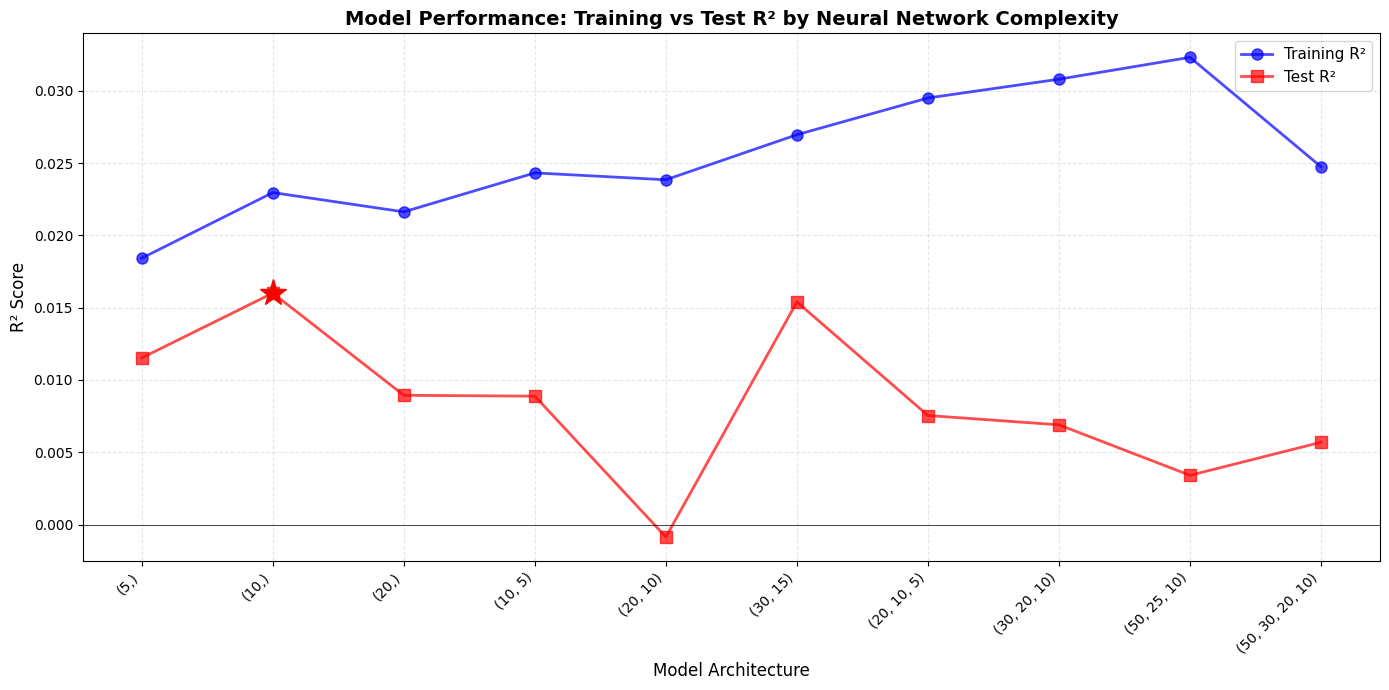

In [12]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(complexity_labels))

# Plot both lines
ax.plot(x_pos, train_r2_scores, 'o-', linewidth=2, markersize=8, 
        label='Training R²', color='blue', alpha=0.7)
ax.plot(x_pos, test_r2_scores, 's-', linewidth=2, markersize=8, 
        label='Test R²', color='red', alpha=0.7)

# Customize the plot
ax.set_xlabel('Model Architecture', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Model Performance: Training vs Test R² by Neural Network Complexity', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(complexity_labels, rotation=45, ha='right')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add annotation for best test performance
ax.plot(best_test_idx, test_r2_scores[best_test_idx], 'r*', 
        markersize=20, label='Best Test Performance')

plt.tight_layout()
plt.show()

## Analysis: Overfitting vs Model Complexity

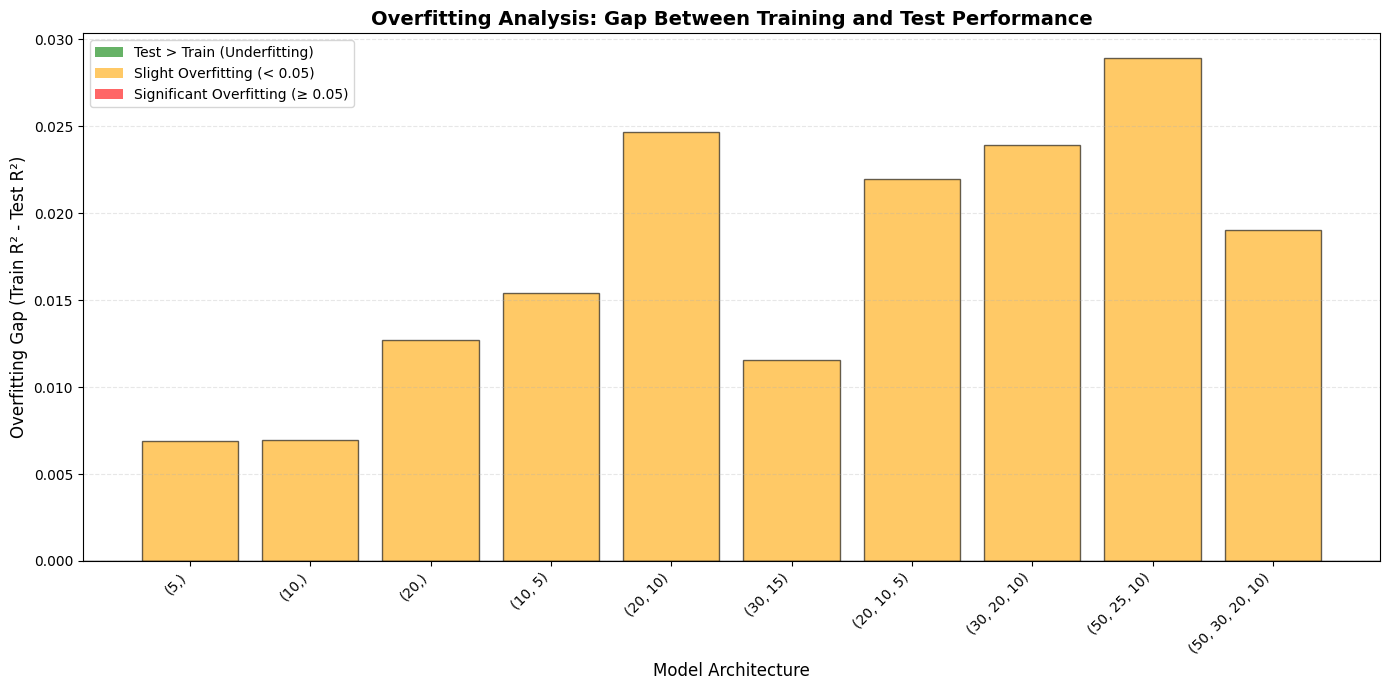

In [13]:
# Plot the difference (overfitting gap)
fig, ax = plt.subplots(figsize=(14, 7))

overfitting_gap = np.array(train_r2_scores) - np.array(test_r2_scores)
colors = ['green' if gap < 0 else 'orange' if gap < 0.05 else 'red' 
          for gap in overfitting_gap]

bars = ax.bar(x_pos, overfitting_gap, color=colors, alpha=0.6, edgecolor='black')

ax.set_xlabel('Model Architecture', fontsize=12)
ax.set_ylabel('Overfitting Gap (Train R² - Test R²)', fontsize=12)
ax.set_title('Overfitting Analysis: Gap Between Training and Test Performance', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(complexity_labels, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, label='Test > Train (Underfitting)'),
    Patch(facecolor='orange', alpha=0.6, label='Slight Overfitting (< 0.05)'),
    Patch(facecolor='red', alpha=0.6, label='Significant Overfitting (≥ 0.05)')
]
ax.legend(handles=legend_elements, fontsize=10, loc='best')

plt.tight_layout()
plt.show()

## Key Findings

1. **Model Complexity**: As we increase the number of layers and neurons, the model becomes more complex and can capture more intricate patterns in the data.

2. **Training Performance**: More complex models typically achieve higher R² scores on the training data, as they have more capacity to fit the training examples.

3. **Test Performance**: The test R² may not improve monotonically with complexity. At some point, additional complexity may lead to overfitting, where the model memorizes training data patterns that don't generalize.

4. **Overfitting**: The gap between training and test R² indicates overfitting. A large positive gap suggests the model is too complex for the available data.

5. **Optimal Model**: The best model balances training performance with generalization to test data, typically not the most complex model.